In [1]:
import argparse
import os
import pickle
import random
import sys
import time
from importlib import import_module
from scipy import sparse
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import matplotlib.pyplot as plt
from skimage.transform import rotate
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from data import ArgoDataset as Dataset, from_numpy, ref_copy, collate_fn
from utils import Logger, load_pretrain, gpu, to_long,  Optimizer, StepLR
torch.cuda.set_device(2)


config["preprocess"] = False

In [2]:
am = ArgoverseMap()

In [3]:
data_path = '/data/fyy/lanegcn/dataset/dataset/train/data'
avl = ArgoverseForecastingLoader(data_path)
avl.seq_list = sorted(avl.seq_list)

In [5]:
len(avl.seq_list)

205942

In [6]:
def get_traj_and_lane(idx): 
    city_name = copy.deepcopy(avl[idx].city)
    data_seq = copy.deepcopy(avl[idx].seq_df)   # (len, 6)
    timestamp = np.sort(np.unique(data_seq['TIMESTAMP'].values))
    
    mapping = dict()
    for i, ts in enumerate(timestamp):
        mapping[ts] = i
        
    # 某个场景下的所有轨迹，5s内的轨迹，(len, 2)
    trajs = np.concatenate((
            data_seq.X.to_numpy().reshape(-1, 1),
            data_seq.Y.to_numpy().reshape(-1, 1)), 1)

    steps = [mapping[x] for x in data_seq['TIMESTAMP'].values]
    steps = np.asarray(steps, np.int64)

    objs = data_seq.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
    keys = list(objs.keys())
    obj_type = [x[1] for x in keys]

    av_idx = obj_type.index('AV')  # av_index = 0，获取AV的索引
    idcs = objs[keys[av_idx]]

    av_traj = trajs[idcs]  # av_traj.shape = (50, 2)
    av_step = steps[idcs]  # av_step.shape = (50,)
    
    # 获取周围车辆的轨迹
    del keys[av_idx]
    ctx_trajs, ctx_steps = [], []  
    for key in keys:
        idcs = objs[key]
        ctx_trajs.append(trajs[idcs])
        ctx_steps.append(steps[idcs])
        
    data = dict()
    data['city'] = city_name
    data['trajs'] = [av_traj] + ctx_trajs
    data['steps'] = [av_step] + ctx_steps
    data['argo_id'] = int(avl.seq_list[idx].name[:-4])
    
    av_lane = am.get_lane_ids_in_xy_bbox(av_traj[0][0], av_traj[0][1], city_name, 5)
    return av_traj, av_lane, timestamp[0], city_name

In [7]:
from tqdm import tqdm

idx_timestamp_ = {'PIT': [], 'MIA': []}

# 获取总的迭代次数
total_iterations = len(avl.seq_list)

# 使用tqdm包装迭代
for idx in tqdm(range(total_iterations), desc="Sorting data"):
    _, _, timestamp, city_name = get_traj_and_lane(idx)
    idx_timestamp_[city_name].append((idx, timestamp))

idx_timestamps = {}
for key in idx_timestamp_.keys():
    df = pd.DataFrame(idx_timestamp_[key], columns=['Index', 'Timestamp'])
    df = df.sort_values(by='Timestamp')
    idx_timestamps[key] = df


Sorting data: 100%|██████████| 205942/205942 [1:02:04<00:00, 55.30it/s]


In [8]:
import pickle
file_name = '/data/fyy/new_prediction/argoverse copy/intersection_data/train_idx_timestamps.pkl'
# with open(file_name, 'wb') as file:   # 存
#     pickle.dump(idx_timestamps, file)

with open(file_name, 'rb') as file:   # 读
    val_idx_timestamps = pickle.load(file)


: 

In [6]:
# 读取PIT和MIA的十字路口的lane_id
intersection_data_path = [
    'intersection_data/PIT/intersection_PIT_id.pickle',
    'intersection_data/MIA/intersection_MIA_id.pickle'
]
intersection_data = {}
for path in intersection_data_path:
    with open(path, 'rb') as file:
        data = pickle.load(file)
    
    file_name = path.split('/')[-2]
    intersection_data[file_name] = data

In [ ]:
# from tqdm import tqdm
# # 获取十字路口的轨迹，保存数据集中场景的索引idx，train大概需要70min，不用运行这个
# intersection_data_idx = {'PIT': [], 'MIA': []}

# for idx in tqdm(range(len(avl.seq_list)), desc="Processing"):
#     av_traj, av_lane, _, city_name = get_traj_and_lane(idx)
#     # city_name = avl[idx].city
#     for lane_id in av_lane:
#         if lane_id in intersection_data[str(city_name)]:
#             intersection_data_idx[str(city_name)].append(idx)
#             break

In [8]:
# file_name = '/data/fyy/new_prediction/argoverse copy/intersection_data/intersection_train_data_idx.pkl'

# # with open(file_name, 'wb') as file:
# #     pickle.dump(intersection_data_idx, file)
    
# with open(file_name, 'rb') as file:
#     intersection_data_idx = pickle.load(file)

In [12]:
# print("PIT处于十字路口的片段数量", len(intersection_data_idx['PIT']))
# print("MIA处于十字路口的片段数量", len(intersection_data_idx['MIA']))

PIT处于十字路口的片段数量 40462
MIA处于十字路口的片段数量 49236


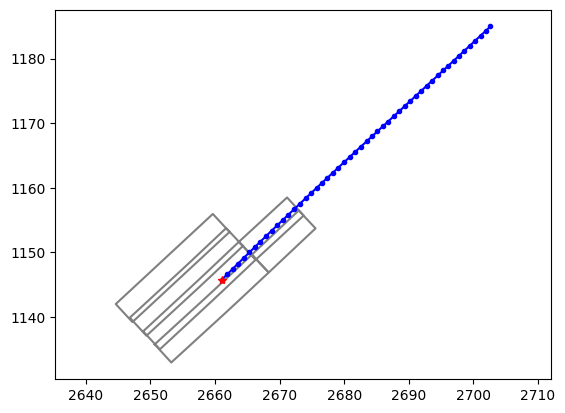

In [11]:
for idx in range(2):
    av_traj, av_lane, _, city_name = get_traj_and_lane(idx)
    city_name = avl[idx].city
    if city_name == 'PIT':
        for lane_id in av_lane:
            polygon = am.get_lane_segment_polygon(lane_id, city_name)
            if lane_id in intersection_data['PIT']:
                plt.plot(polygon[:, 0], polygon[:, 1], 'black')
            else:
                plt.plot(polygon[:, 0], polygon[:, 1], 'grey')
                
        plt.plot(av_traj[:, 0], av_traj[:, 1], marker='.', linestyle='-', color='b')
        plt.plot(av_traj[0, 0], av_traj[0, 1], marker='*', linestyle='-', color='r')

    plt.axis('equal')

In [13]:
from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.geometry import Polygon

# 统计意图预测的数据集，前20帧在停止先前，且至少15帧的轨迹在十字路口内（能够标注意图）
intention_data = []
for idx in tqdm(range(len(avl.seq_list))):
    av_traj, av_lane, _, city_name = get_traj_and_lane(idx)
    
    # 统计这条轨迹的周围路段
    traj_start, traj_end = av_traj[0], av_traj[-1]
    lane_nearest = am.get_lane_ids_in_xy_bbox(traj_start[0], traj_start[1], city_name, 5)
    lane_nearest += am.get_lane_ids_in_xy_bbox(traj_end[0], traj_end[1], city_name, 5)

    # 获取交叉路口的多边形
    intersection_polygon = []
    for lane_id in lane_nearest:
        if lane_id in intersection_data[city_name]:
            polygon = Polygon(am.get_lane_segment_polygon(lane_id, city_name))
            if polygon.is_valid:
                intersection_polygon.append(polygon)
    merged_polygon_intersection = unary_union(intersection_polygon) if intersection_polygon else None  
    
    # 获取直行道路的多边形
    straight_road_polygon = []
    for lane_id in lane_nearest:
        if lane_id in intersection_data[city_name]: continue
        polygon = Polygon(am.get_lane_segment_polygon(lane_id, city_name))
        if polygon.is_valid:
            straight_road_polygon.append(polygon)
    merged_polygon_straight_road = unary_union(straight_road_polygon) if straight_road_polygon else None
           
    # 统计轨迹在直行道路内的帧数       
    frames_inside_straight = 0
    for x, y in av_traj[:20]:
        point = Point(x, y)
        if merged_polygon_straight_road and merged_polygon_straight_road.contains(point):
            frames_inside_straight += 1
    
    # 统计轨迹在交叉路口内的帧数
    frames_inside_intersection = 0
    for x, y in av_traj[20:]:
        point = Point(x, y)
        if merged_polygon_intersection and merged_polygon_intersection.contains(point):
            frames_inside_intersection += 1

    if frames_inside_straight == 20 and frames_inside_intersection > 15:
        intention_data.append(idx)
        

100%|██████████| 205942/205942 [2:27:22<00:00, 23.29it/s]   


In [15]:
file_name = '/data/fyy/new_prediction/argoverse copy/intersection_data/intention_train_av_idx.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(intention_data, file)
    
# with open(file_name, 'rb') as file:
#     intention_data = pickle.load(file)

print("意图数据的数量", len(intention_data))

意图数据的数量 8540


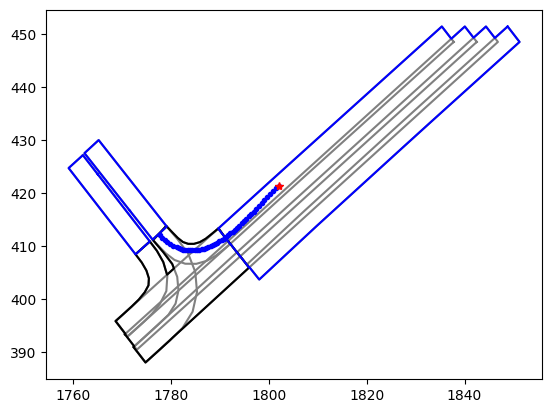

In [21]:
from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.geometry import Polygon

i = 11
idx = intention_data[i]
av_traj, av_lane, _, city_name = get_traj_and_lane(idx)

traj_start, traj_end = av_traj[0], av_traj[-1]
lane_nearest = am.get_lane_ids_in_xy_bbox(traj_start[0], traj_start[1], city_name, 4)
lane_nearest += am.get_lane_ids_in_xy_bbox(traj_end[0], traj_end[1], city_name, 4)

intersection_polygons = []  # 存储十字路口的多边形
straight_road_polygons = []  # 存储直道的多边形

for lane_id in lane_nearest:
    polygon = Polygon(am.get_lane_segment_polygon(lane_id, city_name))
    if polygon.is_valid:
        if lane_id in intersection_data[city_name]:  # 判断是否是十字路口
            intersection_polygons.append(polygon)
            plt.plot(am.get_lane_segment_polygon(lane_id, city_name)[:, 0], am.get_lane_segment_polygon(lane_id, city_name)[:, 1], 'grey')
        else:
            straight_road_polygons.append(polygon)
            plt.plot(am.get_lane_segment_polygon(lane_id, city_name)[:, 0], am.get_lane_segment_polygon(lane_id, city_name)[:, 1], 'grey')
    
# 合并多边形
merged_intersection_polygon = unary_union(intersection_polygons) if intersection_polygons else None
merged_straight_road_polygon = unary_union(straight_road_polygons) if straight_road_polygons else None
    
# 绘制多边形
if merged_intersection_polygon:
    if merged_intersection_polygon.geom_type == 'MultiPolygon':
        for polygon in merged_intersection_polygon.geoms: 
            x, y = polygon.exterior.xy
            plt.plot(x, y, 'black')
    else:
        x, y = merged_intersection_polygon.exterior.xy
        plt.plot(x, y, 'black')

if merged_straight_road_polygon:
    if merged_straight_road_polygon.geom_type == 'MultiPolygon':
        for polygon in merged_straight_road_polygon.geoms: 
            x, y = polygon.exterior.xy
            plt.plot(x, y, 'b')
    else:
        x, y = merged_straight_road_polygon.exterior.xy
        plt.plot(x, y, 'b')


plt.plot(av_traj[:, 0], av_traj[:, 1], marker='.', linestyle='-', color='b')
plt.plot(av_traj[0, 0], av_traj[0, 1], marker='*', linestyle='-', color='r')

